In [1]:
import collections
import itertools
import os
import multiprocessing
import pickle
import random

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import transformers
from sklearn.metrics import ConfusionMatrixDisplay

from utils import *

In [2]:
data_dir = '../data/N2C2-Track3-May3/'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'), low_memory=False)
print(f'Train {len(df_train)} rows')
df_dev = pd.read_csv(os.path.join(data_dir, 'dev.csv'), low_memory=False)
print(f'Dev {len(df_dev)} rows')

Train 4633 rows
Dev 597 rows


In [3]:
_relation_labels = {'Direct': 0, 'Indirect': 1, 'Neither': 2, 'Not Relevant': 3}
relations, labels = list(zip(*_relation_labels.items()))
relation_to_label = _relation_labels
label_to_relation = {v: k for k, v in relation_to_label.items()}
num_labels = len(relation_to_label)

In [4]:
train_labels = np.array([relation_to_label[r] for r in df_train['Relation']])
dev_labels = np.array([relation_to_label[r] for r in df_dev['Relation']])

## Accuracy / conf matrix

In [5]:
def confusion_matrix_strs(y_true, y_pred, dataset=''):
    conf_mat = sklearn.metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
    results = []
    results.append(f'{dataset.upper():<9}' + ' '.join([f'{r[:8]:>8}' for r in relations]) + '  Lbl cnt')
    for i in range(4):
        results.append(f'{relations[i][:8]:>8} ' + ' '.join([f'{c:8}' for c in conf_mat[i]]) + f' {sum(conf_mat[i]):8}')    
    results.append(f'Pred cnt ' + ' '.join([f'{sum(conf_mat[:,i]):8}' for i in range(4)]) + f' {np.sum(conf_mat):8}')    
    return results

def plot_confusion_matrix_traindev(train_preds, dev_preds, train_labels=train_labels, dev_labels=dev_labels):
    plt.figure(figsize=(12, 4))
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay.from_predictions(y_true=train_labels, y_pred=train_preds, normalize='true', cmap=plt.cm.Blues, ax=ax)
    plt.title('Train prediction'); plt.xticks(*zip(*label_to_relation.items())); plt.yticks(*zip(*label_to_relation.items()))
    ax = plt.subplot(1, 2, 2)
    ConfusionMatrixDisplay.from_predictions(y_true=dev_labels, y_pred=dev_preds, normalize='true', cmap=plt.cm.Blues, ax=ax)
    plt.title('Dev prediction'); plt.xticks(*zip(*label_to_relation.items())); plt.yticks(*zip(*label_to_relation.items()))

    train_correct = train_labels == train_preds
    dev_correct = dev_labels == dev_preds
    print(f'- Train set performance')
    print(f'    - Accuracy: {np.mean(train_correct):.6f} ({sum(train_correct)}/{len(train_correct)})')
    print(f'    - Macro F1: {sklearn.metrics.f1_score(y_true=train_labels, y_pred=train_preds, average="macro"):.6f}')
    print(f'- Dev set performance')
    print(f'    - Accuracy: {np.mean(dev_correct):.6f} ({sum(dev_correct)}/{len(dev_correct)})')
    print(f'    - Macro F1: {sklearn.metrics.f1_score(y_true=dev_labels, y_pred=dev_preds, average="macro"):.6f}')
    
    train_conf_strs = confusion_matrix_strs(train_labels, train_preds, 'train')
    dev_conf_strs = confusion_matrix_strs(dev_labels, dev_preds, 'dev')
    for str1, str2 in zip(train_conf_strs, dev_conf_strs):
        print(str1 + ' | ' + str2)

def plot_results(results_dir, ckpt_step=9999):
    print(f'[Experiment {results_dir}, step {ckpt_step}]')
    with open(os.path.join(results_dir, f'results_train_{ckpt_step}.pkl'), 'rb') as fd:
        train_results = pickle.load(fd)
    with open(os.path.join(results_dir, f'results_dev_{ckpt_step}.pkl'), 'rb') as fd:
        dev_results = pickle.load(fd)
    train_preds = np.argmax(np.array([r['logits'] for r in train_results]), axis=1)
    dev_preds = np.argmax(np.array([r['logits'] for r in dev_results]), axis=1)
    plot_confusion_matrix_traindev(train_preds, dev_preds)

def softmax(logits):
    logits = np.array(logits)
    logits -= (np.max(logits, axis=1, keepdims=True) - np.min(logits, axis=1, keepdims=True)) / 2
    exps = np.exp(logits)
    return exps / np.sum(exps, axis=1, keepdims=True)

def get_ensemble(dir_step_list, split='train', ensemble='logits'):
    logitss = []
    for results_dir, ckpt_step in dir_step_list:
        with open(os.path.join(results_dir, f'results_{split}_{ckpt_step}.pkl'), 'rb') as fd:
            results = pickle.load(fd)
        logitss.append(np.array([r['logits'] for r in results]))
        
    if ensemble == "logits":
        values = np.array(logitss).mean(axis=0)
    elif ensemble == "probs":
        values = np.array([softmax(logits) for logits in logitss]).mean(axis=0)
    else:
        raise ValueError(f"Wrong emsenble value: {ensemble}") 
    return values
    
def plot_results_ensemble(dir_step_list, ensemble="logits"):
    print('Ensemble of following results')    
    for results_dir, ckpt_step in dir_step_list:
        print(f'\t({results_dir}, step {ckpt_step})')  
        
    train_values = get_ensemble(dir_step_list, split='train', ensemble=ensemble)
    dev_values = get_ensemble(dir_step_list, split='dev', ensemble=ensemble)
    
    train_preds = np.argmax(train_values, axis=1)
    dev_preds = np.argmax(dev_values, axis=1)
    plot_confusion_matrix_traindev(train_preds, dev_preds)       

### Load all the train/dev predictions

In [6]:
exp_names = sorted(os.listdir('../results/'))
exp_names = [n for n in exp_names if ('backup' not in n)
                                     and ('traindev' not in n)
                                     and ('sent_sim' not in n)
#                                      and ('bert-base-uncased' not in n)
                                     and ('2gpu' not in n)
#                                      and ('noshuffle' in n)
#                                      and ('noshuffle' not in n)
#                                      and ('Longformer_' not in n)
#                                      and ('Longformer2' not in n)
            ]
exp_names

['sent_rel_BioClinicalBERT',
 'sent_rel_BioClinicalBERT_noshuffle',
 'sent_rel_BlueBERT-Base',
 'sent_rel_BlueBERT-Base_noshuffle',
 'sent_rel_BlueBERT-Large',
 'sent_rel_BlueBERT-Large_noshuffle',
 'sent_rel_Clinical-Longformer',
 'sent_rel_Clinical-Longformer2',
 'sent_rel_Clinical-Longformer2_noshuffle',
 'sent_rel_Clinical-Longformer_noshuffle',
 'sent_rel_PubMedBERT',
 'sent_rel_PubMedBERT_noshuffle',
 'sent_rel_bert-base-uncased',
 'sent_rel_bert-base-uncased_noshuffle']

In [7]:
ckpt_steps = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 9999]

exp_dev_logits = {}
exp_dev_results = {}

for exp_name in exp_names:
#     results_dir = os.path.join('../results', exp_name)
    dev_logitss, dev_accs, dev_f1s = {}, [], []
    for step in ckpt_steps:
        with open(f'../results/{exp_name}/results_dev_{step}.pkl', 'rb') as fd:
            dev_results = pickle.load(fd)
        dev_logits = np.array([r['logits'] for r in dev_results])
        dev_logitss[step] = dev_logits
        dev_preds = np.argmax(dev_logits, axis=1)
        dev_accs.append(np.mean(dev_labels == dev_preds))
        dev_f1s.append(sklearn.metrics.f1_score(y_true=dev_labels, y_pred=dev_preds, average="macro"))
    exp_dev_logits[exp_name] = dev_logitss
    exp_dev_results[exp_name] = (dev_accs, dev_f1s)

- Split dev dataset into two

In [8]:
# Split dev dataset into two
def split_idxs_by_column(df_data, col_name):
    idxs_seq = []
    cur_idxs, last_col_id = [], df_data[col_name][0]
    for i, row in df_data.iterrows():
        col_id = row[col_name]
        if col_id != last_col_id:
            idxs_seq.append(cur_idxs)
            cur_idxs, last_col_id = [], col_id
        cur_idxs.append(i)
    idxs_seq.append(cur_idxs)
    return idxs_seq

dev_idxs_seq = split_idxs_by_column(df_dev, 'ROW ID')

seq_idxs = list(range(len(dev_idxs_seq)))
random.seed(123)
random.shuffle(seq_idxs)

dev1_idxs = [i for si in seq_idxs[:len(dev_idxs_seq)//2] for i in dev_idxs_seq[si]]
dev2_idxs = [i for si in seq_idxs[len(dev_idxs_seq)//2:] for i in dev_idxs_seq[si]]
assert len(df_dev) == len(set(dev1_idxs) | set(dev2_idxs))
print(f'Dev set {len(df_dev)} -> {len(dev1_idxs)} / {len(dev2_idxs)}')
dev1_labels = dev_labels[dev1_idxs]
dev2_labels = dev_labels[dev2_idxs]

Dev set 597 -> 295 / 302


- Compute the acc and F1 score on each split

In [9]:
ckpt_steps = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 9999]

def plot_splitdev_results(results_dir):
    dev1_accs, dev2_accs = [], []
    dev1_f1s, dev2_f1s = [], []
    for step in ckpt_steps:
        with open(os.path.join(results_dir, f'results_dev_{step}.pkl'), 'rb') as fd:
            dev_results = pickle.load(fd)
        dev_logits = np.array([r['logits'] for r in dev_results])
        dev1_logits = dev_logits[dev1_idxs]
        dev2_logits = dev_logits[dev2_idxs]
        dev1_preds = np.argmax(dev1_logits, axis=1)
        dev2_preds = np.argmax(dev2_logits, axis=1)

        dev1_accs.append(np.mean(dev1_labels == dev1_preds))
        dev2_accs.append(np.mean(dev2_labels == dev2_preds))
        dev1_f1s.append(sklearn.metrics.f1_score(y_true=dev1_labels, y_pred=dev1_preds, average="macro"))
        dev2_f1s.append(sklearn.metrics.f1_score(y_true=dev2_labels, y_pred=dev2_preds, average="macro"))
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(results_dir)
    plt.plot(ckpt_steps, dev1_accs, 'b-', label='acc 1')
    plt.plot(ckpt_steps, dev2_accs, 'r-', label='acc 2')
    plt.grid()
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(ckpt_steps, dev1_f1s, 'b-', label='F1 1')
    plt.plot(ckpt_steps, dev2_f1s, 'r-', label='F1 2')
    plt.grid()
    plt.legend()
    
    return dev1_accs, dev2_accs, dev1_f1s, dev2_f1s

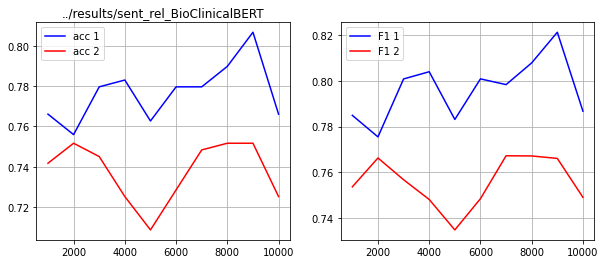

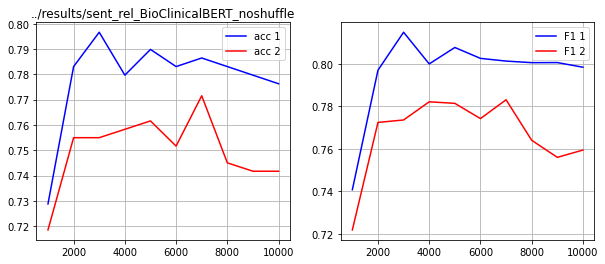

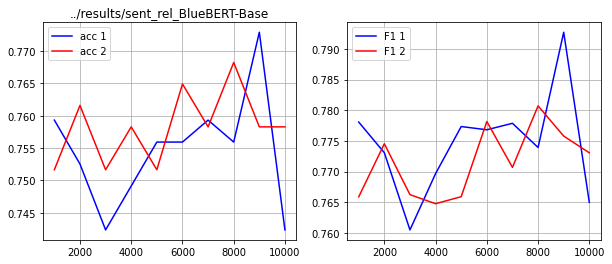

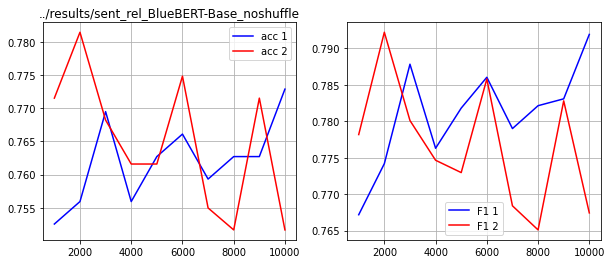

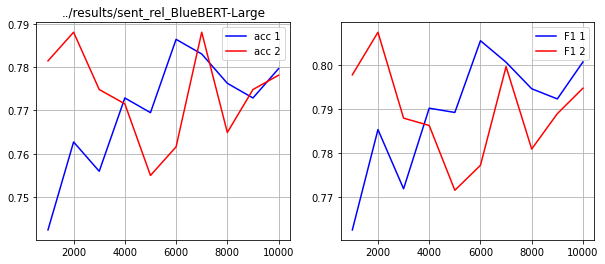

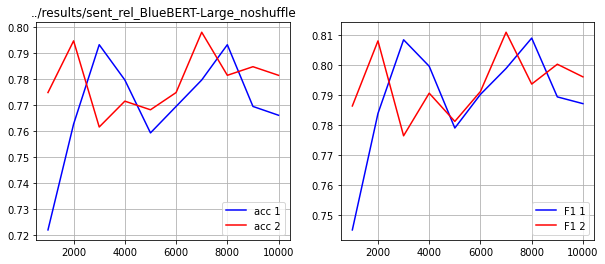

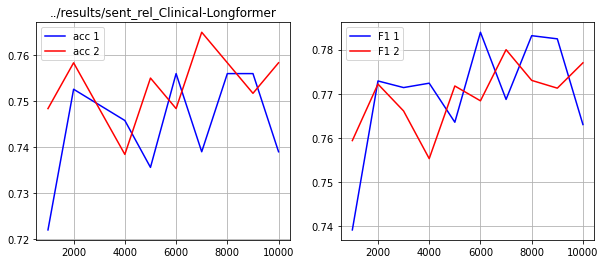

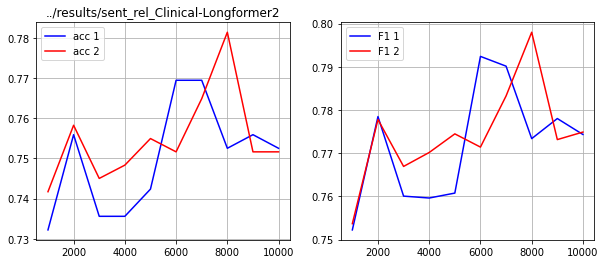

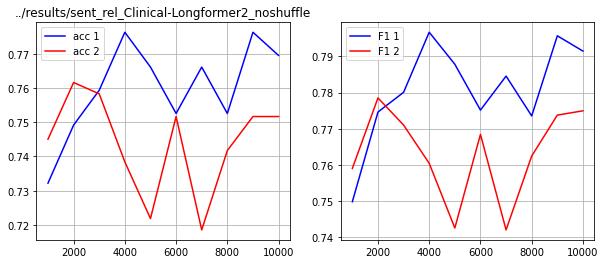

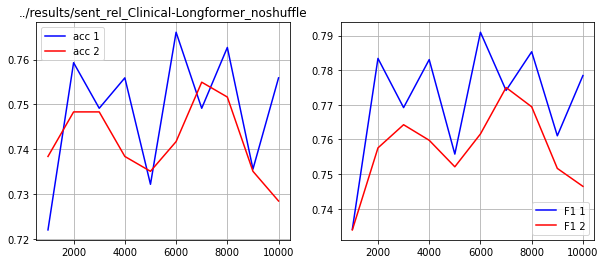

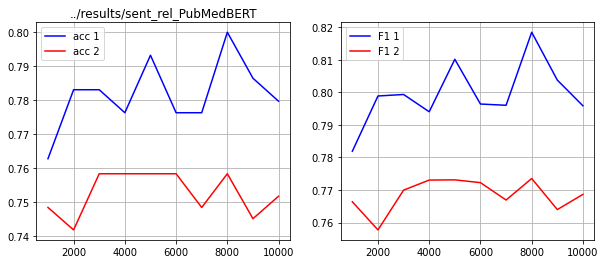

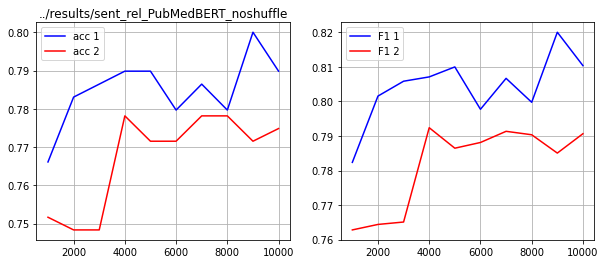

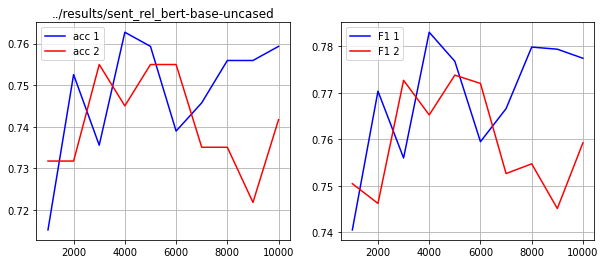

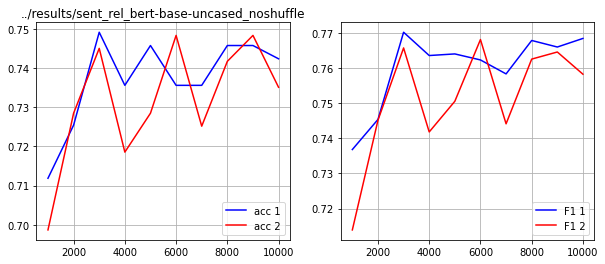

In [10]:
dev_split_results = {}
for exp_name in exp_names:
    results_dir = os.path.join('../results', exp_name)
    dev1_accs, dev2_accs, dev1_f1s, dev2_f1s = plot_splitdev_results(results_dir)
    dev_split_results[exp_name] = (dev1_accs, dev2_accs, dev1_f1s, dev2_f1s)    

## Ensemble 1. Fitting to dev set

In [11]:
def fit_and_eval_devsplit(exp_names, fit_set, eval_set, use_all=False, ind=False):
    print(f"Fit dev set {fit_set} on these combinations")
    exp_ckpt_dict = {}
    for exp_name in exp_names:
        dev1_accs, dev2_accs, dev1_f1s, dev2_f1s = dev_split_results[exp_name]
        if not use_all:
            exp_ckpt_dict[exp_name] = [ckpt_steps[np.argmax(dev1_f1s if fit_set == 1 else dev2_f1s)]]
        else:
            exp_ckpt_dict[exp_name] = [0, ckpt_steps[np.argmax(dev1_f1s if fit_set == 1 else dev2_f1s)]]
        if not ind and exp_ckpt_dict[exp_name][-1] != ckpt_steps[-1]:
            exp_ckpt_dict[exp_name].append(ckpt_steps[-1])
        print(f"    {exp_name:<40}: {exp_ckpt_dict[exp_name]}")
        
    exp_logits_dict = {}
    for exp_name in exp_names:
        exp_logits_dict[exp_name] = {}
        for ckpt_step in exp_ckpt_dict[exp_name]:
            if ckpt_step == 0:
                dev_logits = np.zeros((len(df_dev), 4))
            else:
                with open(os.path.join(f'../results/{exp_name}', f'results_dev_{ckpt_step}.pkl'), 'rb') as fd:
                    dev_results_temp = pickle.load(fd)
                dev_logits = np.array([r['logits'] for r in dev_results_temp])
            exp_logits_dict[exp_name][ckpt_step] = dev_logits

    fit_labels = dev_labels[dev1_idxs if fit_set == 1 else dev2_idxs]
    eval_labels = dev_labels[dev1_idxs if eval_set == 1 else dev2_idxs]

    best_step_list, best_dev_macro_f1 = (), 0.8
    for step_list in itertools.product(*[exp_ckpt_dict[exp_name] for exp_name in exp_names]):
        fit_values = np.zeros((len(df_dev), 4), dtype=np.float32)
        for exp_name, step in zip(exp_names, step_list):
            dev_logits = exp_logits_dict[exp_name][step]
            fit_values += softmax(dev_logits)
        fit_preds = np.argmax(fit_values, axis=1)[dev1_idxs if fit_set == 1 else dev2_idxs]
        macro_f1 = sklearn.metrics.f1_score(y_true=fit_labels, y_pred=fit_preds, average="macro")
        if macro_f1 > best_dev_macro_f1:
            best_step_list, best_dev_macro_f1 = step_list, macro_f1
            print(f'{step_list}: {macro_f1:.6f}')

    eval_values = np.zeros((len(df_dev), 4), dtype=np.float32)
    for exp_name, step in zip(exp_names, best_step_list):
        dev_logits = exp_logits_dict[exp_name][step]
        eval_values += softmax(dev_logits)
    eval_preds = np.argmax(eval_values, axis=1)[dev1_idxs if eval_set == 1 else dev2_idxs]
    print(f'Eval on dev set {eval_set} -> {sklearn.metrics.f1_score(y_true=eval_labels, y_pred=eval_preds, average="macro")}')

### Ensemble 1-1. Independent fit (ckpt step is fit to a dev split for each model independently)

In [12]:
# Clinical BERTs, Shuffle X
exp_names = [
    'sent_rel_PubMedBERT_noshuffle',
    'sent_rel_BioClinicalBERT_noshuffle',
    'sent_rel_BlueBERT-Base_noshuffle',
    'sent_rel_BlueBERT-Large_noshuffle',
]

In [13]:
fit_and_eval_devsplit(exp_names, fit_set=1, eval_set=2, ind=True)

Fit dev set 1 on these combinations
    sent_rel_PubMedBERT_noshuffle           : [9000]
    sent_rel_BioClinicalBERT_noshuffle      : [3000]
    sent_rel_BlueBERT-Base_noshuffle        : [9999]
    sent_rel_BlueBERT-Large_noshuffle       : [8000]
(9000, 3000, 9999, 8000): 0.823842
Eval on dev set 2 -> 0.7861392837324455


In [14]:
fit_and_eval_devsplit(exp_names, fit_set=2, eval_set=1, ind=True)

Fit dev set 2 on these combinations
    sent_rel_PubMedBERT_noshuffle           : [4000]
    sent_rel_BioClinicalBERT_noshuffle      : [7000]
    sent_rel_BlueBERT-Base_noshuffle        : [2000]
    sent_rel_BlueBERT-Large_noshuffle       : [7000]
(4000, 7000, 2000, 7000): 0.809298
Eval on dev set 1 -> 0.8330350191163207


In [15]:
# All models, Shuffle X
exp_names = [
    'sent_rel_PubMedBERT_noshuffle',
    'sent_rel_BioClinicalBERT_noshuffle',
    'sent_rel_BlueBERT-Base_noshuffle',
    'sent_rel_BlueBERT-Large_noshuffle',
    'sent_rel_Clinical-Longformer_noshuffle',
    'sent_rel_Clinical-Longformer2_noshuffle',
]

In [16]:
fit_and_eval_devsplit(exp_names, fit_set=1, eval_set=2, ind=True)

Fit dev set 1 on these combinations
    sent_rel_PubMedBERT_noshuffle           : [9000]
    sent_rel_BioClinicalBERT_noshuffle      : [3000]
    sent_rel_BlueBERT-Base_noshuffle        : [9999]
    sent_rel_BlueBERT-Large_noshuffle       : [8000]
    sent_rel_Clinical-Longformer_noshuffle  : [6000]
    sent_rel_Clinical-Longformer2_noshuffle : [4000]
(9000, 3000, 9999, 8000, 6000, 4000): 0.825117
Eval on dev set 2 -> 0.8082396199764248


In [17]:
fit_and_eval_devsplit(exp_names, fit_set=2, eval_set=1, ind=True)

Fit dev set 2 on these combinations
    sent_rel_PubMedBERT_noshuffle           : [4000]
    sent_rel_BioClinicalBERT_noshuffle      : [7000]
    sent_rel_BlueBERT-Base_noshuffle        : [2000]
    sent_rel_BlueBERT-Large_noshuffle       : [7000]
    sent_rel_Clinical-Longformer_noshuffle  : [7000]
    sent_rel_Clinical-Longformer2_noshuffle : [2000]
(4000, 7000, 2000, 7000, 7000, 2000): 0.800535
Eval on dev set 1 -> 0.8325144452120969


In [18]:
# Clinical BERTs, Shuffle O+X
exp_names = [
    'sent_rel_PubMedBERT_noshuffle',
    'sent_rel_PubMedBERT',
    'sent_rel_BioClinicalBERT_noshuffle',
    'sent_rel_BioClinicalBERT',
    'sent_rel_BlueBERT-Base_noshuffle',
    'sent_rel_BlueBERT-Base',
    'sent_rel_BlueBERT-Large_noshuffle',
    'sent_rel_BlueBERT-Large',
]

In [19]:
fit_and_eval_devsplit(exp_names, fit_set=1, eval_set=2, ind=True)

Fit dev set 1 on these combinations
    sent_rel_PubMedBERT_noshuffle           : [9000]
    sent_rel_PubMedBERT                     : [8000]
    sent_rel_BioClinicalBERT_noshuffle      : [3000]
    sent_rel_BioClinicalBERT                : [9000]
    sent_rel_BlueBERT-Base_noshuffle        : [9999]
    sent_rel_BlueBERT-Base                  : [9000]
    sent_rel_BlueBERT-Large_noshuffle       : [8000]
    sent_rel_BlueBERT-Large                 : [6000]
(9000, 8000, 3000, 9000, 9999, 9000, 8000, 6000): 0.828478
Eval on dev set 2 -> 0.8050200127183631


In [20]:
fit_and_eval_devsplit(exp_names, fit_set=2, eval_set=1, ind=True)

Fit dev set 2 on these combinations
    sent_rel_PubMedBERT_noshuffle           : [4000]
    sent_rel_PubMedBERT                     : [8000]
    sent_rel_BioClinicalBERT_noshuffle      : [7000]
    sent_rel_BioClinicalBERT                : [7000]
    sent_rel_BlueBERT-Base_noshuffle        : [2000]
    sent_rel_BlueBERT-Base                  : [8000]
    sent_rel_BlueBERT-Large_noshuffle       : [7000]
    sent_rel_BlueBERT-Large                 : [2000]
(4000, 8000, 7000, 7000, 2000, 8000, 7000, 2000): 0.811527
Eval on dev set 1 -> 0.828921017612012


In [21]:
# All models, Shuffle O+X
exp_names = [
    'sent_rel_PubMedBERT_noshuffle',
    'sent_rel_PubMedBERT',
    'sent_rel_BioClinicalBERT_noshuffle',
    'sent_rel_BioClinicalBERT',
    'sent_rel_BlueBERT-Base_noshuffle',
    'sent_rel_BlueBERT-Base',
    'sent_rel_BlueBERT-Large_noshuffle',
    'sent_rel_BlueBERT-Large',
    'sent_rel_Clinical-Longformer_noshuffle',
    'sent_rel_Clinical-Longformer',
    'sent_rel_Clinical-Longformer2_noshuffle',
    'sent_rel_Clinical-Longformer2',
]

In [22]:
fit_and_eval_devsplit(exp_names, fit_set=1, eval_set=2, ind=True)

Fit dev set 1 on these combinations
    sent_rel_PubMedBERT_noshuffle           : [9000]
    sent_rel_PubMedBERT                     : [8000]
    sent_rel_BioClinicalBERT_noshuffle      : [3000]
    sent_rel_BioClinicalBERT                : [9000]
    sent_rel_BlueBERT-Base_noshuffle        : [9999]
    sent_rel_BlueBERT-Base                  : [9000]
    sent_rel_BlueBERT-Large_noshuffle       : [8000]
    sent_rel_BlueBERT-Large                 : [6000]
    sent_rel_Clinical-Longformer_noshuffle  : [6000]
    sent_rel_Clinical-Longformer            : [6000]
    sent_rel_Clinical-Longformer2_noshuffle : [4000]
    sent_rel_Clinical-Longformer2           : [6000]
(9000, 8000, 3000, 9000, 9999, 9000, 8000, 6000, 6000, 6000, 4000, 6000): 0.823953
Eval on dev set 2 -> 0.7959732777522213


In [23]:
fit_and_eval_devsplit(exp_names, fit_set=2, eval_set=1, ind=True)

Fit dev set 2 on these combinations
    sent_rel_PubMedBERT_noshuffle           : [4000]
    sent_rel_PubMedBERT                     : [8000]
    sent_rel_BioClinicalBERT_noshuffle      : [7000]
    sent_rel_BioClinicalBERT                : [7000]
    sent_rel_BlueBERT-Base_noshuffle        : [2000]
    sent_rel_BlueBERT-Base                  : [8000]
    sent_rel_BlueBERT-Large_noshuffle       : [7000]
    sent_rel_BlueBERT-Large                 : [2000]
    sent_rel_Clinical-Longformer_noshuffle  : [7000]
    sent_rel_Clinical-Longformer            : [7000]
    sent_rel_Clinical-Longformer2_noshuffle : [2000]
    sent_rel_Clinical-Longformer2           : [8000]
(4000, 8000, 7000, 7000, 2000, 8000, 7000, 2000, 7000, 7000, 2000, 8000): 0.806600
Eval on dev set 1 -> 0.8287980573014098


### Ensemble 1-2. Joint fit (ckpt steps of all models are fit jointly to a dev split)

In [24]:
# Clinical BERTs, Shuffle X
exp_names = [
    'sent_rel_PubMedBERT_noshuffle',
    'sent_rel_BioClinicalBERT_noshuffle',
    'sent_rel_BlueBERT-Base_noshuffle',
    'sent_rel_BlueBERT-Large_noshuffle',
]

In [25]:
fit_and_eval_devsplit(exp_names, fit_set=1, eval_set=2)

Fit dev set 1 on these combinations
    sent_rel_PubMedBERT_noshuffle           : [9000, 9999]
    sent_rel_BioClinicalBERT_noshuffle      : [3000, 9999]
    sent_rel_BlueBERT-Base_noshuffle        : [9999]
    sent_rel_BlueBERT-Large_noshuffle       : [8000, 9999]
(9000, 3000, 9999, 8000): 0.823842
(9000, 9999, 9999, 8000): 0.830280
(9000, 9999, 9999, 9999): 0.836178
Eval on dev set 2 -> 0.8018183199202599


In [26]:
fit_and_eval_devsplit(exp_names, fit_set=2, eval_set=1)

Fit dev set 2 on these combinations
    sent_rel_PubMedBERT_noshuffle           : [4000, 9999]
    sent_rel_BioClinicalBERT_noshuffle      : [7000, 9999]
    sent_rel_BlueBERT-Base_noshuffle        : [2000, 9999]
    sent_rel_BlueBERT-Large_noshuffle       : [7000, 9999]
(4000, 7000, 2000, 7000): 0.809298
(4000, 7000, 2000, 9999): 0.811773
(4000, 7000, 9999, 9999): 0.812194
(9999, 7000, 2000, 7000): 0.814985
(9999, 7000, 2000, 9999): 0.818783
Eval on dev set 1 -> 0.8329043120871538


In [27]:
# All models, Shuffle X
exp_names = [
    'sent_rel_PubMedBERT_noshuffle',
    'sent_rel_BioClinicalBERT_noshuffle',
    'sent_rel_BlueBERT-Base_noshuffle',
    'sent_rel_BlueBERT-Large_noshuffle',
    'sent_rel_Clinical-Longformer_noshuffle',
    'sent_rel_Clinical-Longformer2_noshuffle',
]

In [28]:
fit_and_eval_devsplit(exp_names, fit_set=1, eval_set=2)

Fit dev set 1 on these combinations
    sent_rel_PubMedBERT_noshuffle           : [9000, 9999]
    sent_rel_BioClinicalBERT_noshuffle      : [3000, 9999]
    sent_rel_BlueBERT-Base_noshuffle        : [9999]
    sent_rel_BlueBERT-Large_noshuffle       : [8000, 9999]
    sent_rel_Clinical-Longformer_noshuffle  : [6000, 9999]
    sent_rel_Clinical-Longformer2_noshuffle : [4000, 9999]
(9000, 3000, 9999, 8000, 6000, 4000): 0.825117
(9000, 3000, 9999, 8000, 9999, 4000): 0.830581
(9000, 9999, 9999, 8000, 9999, 4000): 0.835326
(9999, 9999, 9999, 8000, 9999, 4000): 0.837864
Eval on dev set 2 -> 0.7925855489550637


In [29]:
fit_and_eval_devsplit(exp_names, fit_set=2, eval_set=1)

Fit dev set 2 on these combinations
    sent_rel_PubMedBERT_noshuffle           : [4000, 9999]
    sent_rel_BioClinicalBERT_noshuffle      : [7000, 9999]
    sent_rel_BlueBERT-Base_noshuffle        : [2000, 9999]
    sent_rel_BlueBERT-Large_noshuffle       : [7000, 9999]
    sent_rel_Clinical-Longformer_noshuffle  : [7000, 9999]
    sent_rel_Clinical-Longformer2_noshuffle : [2000, 9999]
(4000, 7000, 2000, 7000, 7000, 2000): 0.800535
(4000, 7000, 2000, 7000, 7000, 9999): 0.801496
(4000, 7000, 2000, 7000, 9999, 2000): 0.802772
(4000, 7000, 2000, 9999, 7000, 2000): 0.806304
(9999, 7000, 2000, 7000, 7000, 9999): 0.807853
Eval on dev set 1 -> 0.8257644500895388


In [30]:
# Clinical BERTs, Shuffle O+X
exp_names = [
    'sent_rel_PubMedBERT_noshuffle',
    'sent_rel_PubMedBERT',
    'sent_rel_BioClinicalBERT_noshuffle',
    'sent_rel_BioClinicalBERT',
    'sent_rel_BlueBERT-Base_noshuffle',
    'sent_rel_BlueBERT-Base',
    'sent_rel_BlueBERT-Large_noshuffle',
    'sent_rel_BlueBERT-Large',
]

In [31]:
fit_and_eval_devsplit(exp_names, fit_set=1, eval_set=2)

Fit dev set 1 on these combinations
    sent_rel_PubMedBERT_noshuffle           : [9000, 9999]
    sent_rel_PubMedBERT                     : [8000, 9999]
    sent_rel_BioClinicalBERT_noshuffle      : [3000, 9999]
    sent_rel_BioClinicalBERT                : [9000, 9999]
    sent_rel_BlueBERT-Base_noshuffle        : [9999]
    sent_rel_BlueBERT-Base                  : [9000, 9999]
    sent_rel_BlueBERT-Large_noshuffle       : [8000, 9999]
    sent_rel_BlueBERT-Large                 : [6000, 9999]
(9000, 8000, 3000, 9000, 9999, 9000, 8000, 6000): 0.828478
(9000, 8000, 3000, 9000, 9999, 9999, 8000, 9999): 0.830947
(9000, 8000, 9999, 9000, 9999, 9000, 8000, 6000): 0.836448
(9000, 8000, 9999, 9000, 9999, 9000, 8000, 9999): 0.838878
(9000, 9999, 9999, 9000, 9999, 9000, 8000, 6000): 0.839074
(9000, 9999, 9999, 9000, 9999, 9000, 9999, 6000): 0.841901
Eval on dev set 2 -> 0.7970994696883382


In [32]:
fit_and_eval_devsplit(exp_names, fit_set=2, eval_set=1)

Fit dev set 2 on these combinations
    sent_rel_PubMedBERT_noshuffle           : [4000, 9999]
    sent_rel_PubMedBERT                     : [8000, 9999]
    sent_rel_BioClinicalBERT_noshuffle      : [7000, 9999]
    sent_rel_BioClinicalBERT                : [7000, 9999]
    sent_rel_BlueBERT-Base_noshuffle        : [2000, 9999]
    sent_rel_BlueBERT-Base                  : [8000, 9999]
    sent_rel_BlueBERT-Large_noshuffle       : [7000, 9999]
    sent_rel_BlueBERT-Large                 : [2000, 9999]
(4000, 8000, 7000, 7000, 2000, 8000, 7000, 2000): 0.811527
(4000, 8000, 7000, 7000, 2000, 8000, 7000, 9999): 0.816551
(4000, 8000, 7000, 7000, 2000, 8000, 9999, 2000): 0.822129
Eval on dev set 1 -> 0.8260823711914558


In [33]:
# All models, Shuffle O+X
exp_names = [
    'sent_rel_PubMedBERT_noshuffle',
    'sent_rel_PubMedBERT',
    'sent_rel_BioClinicalBERT_noshuffle',
    'sent_rel_BioClinicalBERT',
    'sent_rel_BlueBERT-Base_noshuffle',
    'sent_rel_BlueBERT-Base',
    'sent_rel_BlueBERT-Large_noshuffle',
    'sent_rel_BlueBERT-Large',
    'sent_rel_Clinical-Longformer_noshuffle',
    'sent_rel_Clinical-Longformer',
    'sent_rel_Clinical-Longformer2_noshuffle',
    'sent_rel_Clinical-Longformer2',
]

In [34]:
fit_and_eval_devsplit(exp_names, fit_set=1, eval_set=2)

Fit dev set 1 on these combinations
    sent_rel_PubMedBERT_noshuffle           : [9000, 9999]
    sent_rel_PubMedBERT                     : [8000, 9999]
    sent_rel_BioClinicalBERT_noshuffle      : [3000, 9999]
    sent_rel_BioClinicalBERT                : [9000, 9999]
    sent_rel_BlueBERT-Base_noshuffle        : [9999]
    sent_rel_BlueBERT-Base                  : [9000, 9999]
    sent_rel_BlueBERT-Large_noshuffle       : [8000, 9999]
    sent_rel_BlueBERT-Large                 : [6000, 9999]
    sent_rel_Clinical-Longformer_noshuffle  : [6000, 9999]
    sent_rel_Clinical-Longformer            : [6000, 9999]
    sent_rel_Clinical-Longformer2_noshuffle : [4000, 9999]
    sent_rel_Clinical-Longformer2           : [6000, 9999]
(9000, 8000, 3000, 9000, 9999, 9000, 8000, 6000, 6000, 6000, 4000, 6000): 0.823953
(9000, 8000, 3000, 9000, 9999, 9000, 8000, 6000, 6000, 6000, 4000, 9999): 0.824151
(9000, 8000, 3000, 9000, 9999, 9000, 8000, 6000, 6000, 6000, 9999, 6000): 0.830236
(9000, 8000, 

In [35]:
fit_and_eval_devsplit(exp_names, fit_set=2, eval_set=1)

Fit dev set 2 on these combinations
    sent_rel_PubMedBERT_noshuffle           : [4000, 9999]
    sent_rel_PubMedBERT                     : [8000, 9999]
    sent_rel_BioClinicalBERT_noshuffle      : [7000, 9999]
    sent_rel_BioClinicalBERT                : [7000, 9999]
    sent_rel_BlueBERT-Base_noshuffle        : [2000, 9999]
    sent_rel_BlueBERT-Base                  : [8000, 9999]
    sent_rel_BlueBERT-Large_noshuffle       : [7000, 9999]
    sent_rel_BlueBERT-Large                 : [2000, 9999]
    sent_rel_Clinical-Longformer_noshuffle  : [7000, 9999]
    sent_rel_Clinical-Longformer            : [7000, 9999]
    sent_rel_Clinical-Longformer2_noshuffle : [2000, 9999]
    sent_rel_Clinical-Longformer2           : [8000, 9999]
(4000, 8000, 7000, 7000, 2000, 8000, 7000, 2000, 7000, 7000, 2000, 8000): 0.806600
(4000, 8000, 7000, 7000, 2000, 8000, 7000, 2000, 7000, 9999, 2000, 8000): 0.807238
(4000, 8000, 7000, 7000, 2000, 8000, 7000, 2000, 9999, 9999, 2000, 8000): 0.809797
(4000, 

### Ensemble 1-3. Joint fit on whole dev set

In [38]:
def fit_and_eval(exp_names, use_all=False):
#     print(f"Fit dev set {fit_set} on these combinations")
    exp_ckpt_dict = {}
    for exp_name in exp_names:
        dev_accs, dev_f1s = exp_dev_results[exp_name]
        if use_all:
            exp_ckpt_dict[exp_name] = [0, ckpt_steps[np.argmax(dev_f1s)]]
        else:
            exp_ckpt_dict[exp_name] = [ckpt_steps[np.argmax(dev_f1s)]]
        if exp_ckpt_dict[exp_name][-1] != ckpt_steps[-1]:
            exp_ckpt_dict[exp_name].append(ckpt_steps[-1])
        print(f"    {exp_name:<40}: {exp_ckpt_dict[exp_name]}")

    best_step_list, best_dev_macro_f1 = (), 0.8
    for step_list in itertools.product(*[exp_ckpt_dict[exp_name] for exp_name in exp_names]):
        fit_values = np.zeros((len(df_dev), 4), dtype=np.float32)
        for exp_name, step in zip(exp_names, step_list):
            if step == 0: continue
            dev_logits = exp_dev_logits[exp_name][step]
            fit_values += softmax(dev_logits)
        fit_preds = np.argmax(fit_values, axis=1)
        macro_f1 = sklearn.metrics.f1_score(y_true=dev_labels, y_pred=fit_preds, average="macro")
        if macro_f1 > best_dev_macro_f1:
            best_step_list, best_dev_macro_f1 = step_list, macro_f1
            print(f'{step_list}: {macro_f1:.6f}')

In [40]:
exp_names = [
    'sent_rel_BioClinicalBERT_noshuffle',
    'sent_rel_BlueBERT-Base_noshuffle',
    'sent_rel_BlueBERT-Large_noshuffle',
    'sent_rel_PubMedBERT_noshuffle'
]
fit_and_eval(exp_names, use_all=True)

    sent_rel_BioClinicalBERT_noshuffle      : [0, 5000, 9999]
    sent_rel_BlueBERT-Base_noshuffle        : [0, 6000, 9999]
    sent_rel_BlueBERT-Large_noshuffle       : [0, 7000, 9999]
    sent_rel_PubMedBERT_noshuffle           : [0, 9000, 9999]
(0, 0, 0, 9000): 0.803869
(0, 0, 7000, 0): 0.805841
(0, 0, 9999, 9000): 0.812248
(0, 6000, 0, 9999): 0.813644
(0, 6000, 7000, 0): 0.813659
(0, 6000, 9999, 0): 0.815746
(5000, 0, 7000, 9000): 0.820905
(5000, 0, 9999, 9000): 0.823206


In [41]:
exp_names = [
    'sent_rel_BioClinicalBERT',
    'sent_rel_BioClinicalBERT_noshuffle',
    'sent_rel_BlueBERT-Base',
    'sent_rel_BlueBERT-Base_noshuffle',
    'sent_rel_BlueBERT-Large',
    'sent_rel_BlueBERT-Large_noshuffle',
    'sent_rel_PubMedBERT',
    'sent_rel_PubMedBERT_noshuffle'
]
fit_and_eval(exp_names, use_all=False)

    sent_rel_BioClinicalBERT                : [9000, 9999]
    sent_rel_BioClinicalBERT_noshuffle      : [5000, 9999]
    sent_rel_BlueBERT-Base                  : [9000, 9999]
    sent_rel_BlueBERT-Base_noshuffle        : [6000, 9999]
    sent_rel_BlueBERT-Large                 : [7000, 9999]
    sent_rel_BlueBERT-Large_noshuffle       : [7000, 9999]
    sent_rel_PubMedBERT                     : [8000, 9999]
    sent_rel_PubMedBERT_noshuffle           : [9000, 9999]
(9000, 5000, 9000, 6000, 7000, 7000, 8000, 9000): 0.816980
(9000, 5000, 9000, 6000, 7000, 7000, 8000, 9999): 0.818346
(9000, 5000, 9000, 6000, 7000, 9999, 8000, 9000): 0.818926
(9000, 5000, 9000, 6000, 7000, 9999, 8000, 9999): 0.820278
(9000, 5000, 9000, 6000, 9999, 7000, 8000, 9000): 0.823652
(9000, 5000, 9000, 6000, 9999, 7000, 8000, 9999): 0.823711
(9000, 9999, 9000, 6000, 9999, 7000, 8000, 9999): 0.824296
(9000, 9999, 9000, 6000, 9999, 7000, 9999, 9999): 0.825368
(9000, 9999, 9000, 9999, 9999, 7000, 8000, 9000): 0.8265

In [45]:
exp_names = [
    'sent_rel_BioClinicalBERT',
    'sent_rel_BioClinicalBERT_noshuffle',
    'sent_rel_BlueBERT-Base',
    'sent_rel_BlueBERT-Base_noshuffle',
    'sent_rel_BlueBERT-Large',
    'sent_rel_BlueBERT-Large_noshuffle',
    'sent_rel_PubMedBERT',
    'sent_rel_PubMedBERT_noshuffle'
]
fit_and_eval(exp_names, use_all=True)

    sent_rel_BioClinicalBERT                : [0, 9000, 9999]
    sent_rel_BioClinicalBERT_noshuffle      : [0, 5000, 9999]
    sent_rel_BlueBERT-Base                  : [0, 9000, 9999]
    sent_rel_BlueBERT-Base_noshuffle        : [0, 6000, 9999]
    sent_rel_BlueBERT-Large                 : [0, 7000, 9999]
    sent_rel_BlueBERT-Large_noshuffle       : [0, 7000, 9999]
    sent_rel_PubMedBERT                     : [0, 8000, 9999]
    sent_rel_PubMedBERT_noshuffle           : [0, 9000, 9999]
(0, 0, 0, 0, 0, 0, 0, 9000): 0.803869
(0, 0, 0, 0, 0, 0, 8000, 9000): 0.805473
(0, 0, 0, 0, 0, 7000, 0, 0): 0.805841
(0, 0, 0, 0, 0, 7000, 8000, 0): 0.811774
(0, 0, 0, 0, 0, 7000, 8000, 9999): 0.815623
(0, 0, 0, 0, 0, 9999, 8000, 0): 0.815737
(0, 0, 0, 0, 7000, 7000, 8000, 0): 0.816666
(0, 0, 0, 0, 9999, 0, 8000, 0): 0.817909
(0, 0, 0, 0, 9999, 7000, 8000, 9999): 0.818019
(0, 0, 9000, 0, 0, 7000, 0, 9000): 0.818123
(0, 0, 9999, 6000, 0, 7000, 9999, 9000): 0.820657
(0, 5000, 0, 0, 0, 7000, 0, 9000): 

In [46]:
exp_names = [
    'sent_rel_BlueBERT-Large',
    'sent_rel_BlueBERT-Large_noshuffle',
    'sent_rel_PubMedBERT',
    'sent_rel_PubMedBERT_noshuffle',
    'sent_rel_BioClinicalBERT',
    'sent_rel_BioClinicalBERT_noshuffle',
    'sent_rel_BlueBERT-Base',
    'sent_rel_BlueBERT-Base_noshuffle',
    'sent_rel_Clinical-Longformer2',
    'sent_rel_Clinical-Longformer2_noshuffle',
    'sent_rel_Clinical-Longformer',
    'sent_rel_Clinical-Longformer_noshuffle',
]
fit_and_eval(exp_names, use_all=True)

    sent_rel_BlueBERT-Large                 : [0, 7000, 9999]
    sent_rel_BlueBERT-Large_noshuffle       : [0, 7000, 9999]
    sent_rel_PubMedBERT                     : [0, 8000, 9999]
    sent_rel_PubMedBERT_noshuffle           : [0, 9000, 9999]
    sent_rel_BioClinicalBERT                : [0, 9000, 9999]
    sent_rel_BioClinicalBERT_noshuffle      : [0, 5000, 9999]
    sent_rel_BlueBERT-Base                  : [0, 9000, 9999]
    sent_rel_BlueBERT-Base_noshuffle        : [0, 6000, 9999]
    sent_rel_Clinical-Longformer2           : [0, 7000, 9999]
    sent_rel_Clinical-Longformer2_noshuffle : [0, 9000, 9999]
    sent_rel_Clinical-Longformer            : [0, 8000, 9999]
    sent_rel_Clinical-Longformer_noshuffle  : [0, 8000, 9999]
(0, 0, 0, 0, 0, 0, 0, 0, 9999, 9000, 9999, 8000): 0.800653
(0, 0, 0, 0, 0, 0, 0, 6000, 0, 0, 0, 8000): 0.811197
(0, 0, 0, 0, 0, 0, 0, 6000, 0, 0, 8000, 0): 0.818173
(0, 0, 0, 0, 0, 0, 9000, 6000, 7000, 9000, 0, 9999): 0.823346
(0, 0, 0, 9000, 0, 5000, 9000

$\rightarrow$ Is this really the best combination?  
$\rightarrow$ Check the F1 score nearby combinations and compute mean/var!

- Save all the combination

In [47]:
# Save all the values
exp_ckpt_dict = {}
for exp_name in exp_names:
    dev_accs, dev_f1s = exp_dev_results[exp_name]
    exp_ckpt_dict[exp_name] = [0, ckpt_steps[np.argmax(dev_f1s)]]
    if exp_ckpt_dict[exp_name][-1] != ckpt_steps[-1]:
        exp_ckpt_dict[exp_name].append(ckpt_steps[-1])
    print(f"    {exp_name:<40}: {exp_ckpt_dict[exp_name]}")

    sent_rel_BlueBERT-Large                 : [0, 7000, 9999]
    sent_rel_BlueBERT-Large_noshuffle       : [0, 7000, 9999]
    sent_rel_PubMedBERT                     : [0, 8000, 9999]
    sent_rel_PubMedBERT_noshuffle           : [0, 9000, 9999]
    sent_rel_BioClinicalBERT                : [0, 9000, 9999]
    sent_rel_BioClinicalBERT_noshuffle      : [0, 5000, 9999]
    sent_rel_BlueBERT-Base                  : [0, 9000, 9999]
    sent_rel_BlueBERT-Base_noshuffle        : [0, 6000, 9999]
    sent_rel_Clinical-Longformer2           : [0, 7000, 9999]
    sent_rel_Clinical-Longformer2_noshuffle : [0, 9000, 9999]
    sent_rel_Clinical-Longformer            : [0, 8000, 9999]
    sent_rel_Clinical-Longformer_noshuffle  : [0, 8000, 9999]


In [48]:
def compute_f1(step_list):
    fit_values = np.zeros((len(df_dev), 4), dtype=np.float32)
    for exp_name, step in zip(exp_names, step_list):
        if step == 0: continue
        dev_logits = exp_dev_logits[exp_name][step]
        fit_values += softmax(dev_logits)
    fit_preds = np.argmax(fit_values, axis=1)
    macro_f1 = sklearn.metrics.f1_score(y_true=dev_labels, y_pred=fit_preds, average="macro")
    return macro_f1

work_pool = multiprocessing.Pool(processes=24)

In [49]:
f1_total_values = list(work_pool.imap(compute_f1, itertools.product(*[exp_ckpt_dict[exp_name] for exp_name in exp_names])))

In [50]:
ensemble_total_f1_dict = {}
for step_list, f1_value in zip(itertools.product(*[exp_ckpt_dict[exp_name] for exp_name in exp_names]), f1_total_values):
    ensemble_total_f1_dict[step_list] = f1_value

In [51]:
good_step_lists = []
for step_list, macro_f1 in ensemble_total_f1_dict.items():
    if macro_f1 > 0.83:
        good_step_lists.append((macro_f1, step_list))

- Check neighbor combinations with only 1 coordinate different

In [52]:
def neighbor_f1_mean_std(step_list):
    neighbor_f1s = []
    for i in list(range(len(step_list))):
        for step1 in exp_ckpt_dict[exp_names[i]]:
            if step1 == step_list[i]: continue
            step_list_neighbor = step_list[:i] + (step1,) + step_list[i+1:]
            neighbor_f1s.append(ensemble_total_f1_dict[step_list_neighbor])
    return np.mean(neighbor_f1s), np.std(neighbor_f1s)
        
for macro_f1, step_list in sorted(good_step_lists, reverse=True):
    neighbor_f1_mean, neighbor_f1_std = neighbor_f1_mean_std(step_list)
    print(f'{str(step_list):>70}: {macro_f1:.6f} - {neighbor_f1_mean:.6f} ({neighbor_f1_std:.6f})')

                   (7000, 7000, 0, 0, 0, 0, 9999, 0, 0, 9000, 0, 9999): 0.832330 - 0.823267 (0.004348)
                   (9999, 0, 0, 9000, 0, 0, 9999, 0, 0, 9000, 0, 9999): 0.832100 - 0.822177 (0.005376)
             (7000, 7000, 0, 0, 9000, 0, 9999, 9999, 0, 9000, 0, 9999): 0.831736 - 0.824651 (0.002995)
                (7000, 7000, 0, 9000, 0, 0, 9000, 0, 0, 9000, 0, 9999): 0.831584 - 0.823100 (0.004136)
             (9999, 7000, 8000, 9999, 9000, 0, 0, 0, 9999, 0, 8000, 0): 0.831434 - 0.819678 (0.004967)
                (7000, 7000, 0, 9000, 0, 0, 9999, 0, 0, 9000, 0, 9999): 0.831412 - 0.824804 (0.004246)
                (9999, 7000, 0, 9000, 0, 0, 9999, 0, 0, 9000, 0, 8000): 0.831317 - 0.822447 (0.003945)
                   (9999, 0, 0, 9999, 0, 0, 9999, 0, 0, 9000, 0, 9999): 0.831252 - 0.820159 (0.006138)
                (9999, 7000, 0, 9000, 0, 0, 9000, 0, 0, 9000, 0, 8000): 0.831213 - 0.822495 (0.004087)
                (9999, 7000, 0, 9000, 0, 0, 9999, 0, 0, 9000, 0, 9999): 0

- Check neighbor combinations with up to 2 coordinates different

In [53]:
def neighbor_f1_mean_std2(step_list):
    neighbor_f1s = []
    for i, j in itertools.combinations(list(range(len(step_list))), 2):
        for step1 in exp_ckpt_dict[exp_names[i]]:
            for step2 in exp_ckpt_dict[exp_names[j]]:
                if step1 == step_list[i] and step2 == step_list[j]: continue
                step_list_neighbor = step_list[:i] + (step1,) + step_list[i+1:j] + (step2,) + step_list[j+1:]
                neighbor_f1s.append(ensemble_total_f1_dict[step_list_neighbor])
    return np.mean(neighbor_f1s), np.std(neighbor_f1s)
        
for macro_f1, step_list in sorted(good_step_lists, reverse=True):
    neighbor_f1_mean, neighbor_f1_std = neighbor_f1_mean_std2(step_list)
    print(f'{str(step_list):>70}: {macro_f1:.6f} - {neighbor_f1_mean:.6f} ({neighbor_f1_std:.6f})')

                   (7000, 7000, 0, 0, 0, 0, 9999, 0, 0, 9000, 0, 9999): 0.832330 - 0.821726 (0.005069)
                   (9999, 0, 0, 9000, 0, 0, 9999, 0, 0, 9000, 0, 9999): 0.832100 - 0.820615 (0.005737)
             (7000, 7000, 0, 0, 9000, 0, 9999, 9999, 0, 9000, 0, 9999): 0.831736 - 0.822973 (0.003873)
                (7000, 7000, 0, 9000, 0, 0, 9000, 0, 0, 9000, 0, 9999): 0.831584 - 0.822383 (0.004154)
             (9999, 7000, 8000, 9999, 9000, 0, 0, 0, 9999, 0, 8000, 0): 0.831434 - 0.818638 (0.004659)
                (7000, 7000, 0, 9000, 0, 0, 9999, 0, 0, 9000, 0, 9999): 0.831412 - 0.823285 (0.004521)
                (9999, 7000, 0, 9000, 0, 0, 9999, 0, 0, 9000, 0, 8000): 0.831317 - 0.821194 (0.004342)
                   (9999, 0, 0, 9999, 0, 0, 9999, 0, 0, 9000, 0, 9999): 0.831252 - 0.819284 (0.005812)
                (9999, 7000, 0, 9000, 0, 0, 9000, 0, 0, 9000, 0, 8000): 0.831213 - 0.821215 (0.004375)
                (9999, 7000, 0, 9000, 0, 0, 9999, 0, 0, 9000, 0, 9999): 0

$\rightarrow$ Choose `(0, 0, 0, 9000, 9999, 9999, 7000, 7000, 9999, 0, 9000, 0)`

## Output Test Ensembles

In [54]:
# Test data
df_test = pd.read_csv('../data/N2C2-Track3-May3/test.csv')
df_test.head(10)

,ROW ID,HADM ID,Assessment,Plan Subsection,Relation
0,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Sepsis\n likely has sepsis physiology with hyp...,Direct
1,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Anuria- Renal consulted for anuria- consideri...,Direct
2,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,R pleural effusion: Unilateral nature in the s...,Direct
3,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,DM/hypoglycemia: possibly from not clearing me...,Direct
4,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,S/p recent femur fracture: held SQH overnight,Direct
5,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,"Chronic anemia: stable at baseline, ?thalesemi...",Direct
6,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,"# FEN: NG tube\n # PPx: SC hep, IV ppi, bowe...",Direct
7,560683,194340,ssessment and Plan\n SEPSIS WITHOUT ORGAN DYSF...,#. Sepsis: Patient has re-developed fevers on ...,Direct
8,560683,194340,ssessment and Plan\n SEPSIS WITHOUT ORGAN DYSF...,#. Volume status/Chronic systolic HF- As evide...,Direct
9,560683,194340,ssessment and Plan\n SEPSIS WITHOUT ORGAN DYSF...,#. Peripheral arterial disease: will follow up...,Direct


In [55]:
def get_test_prediction_df(test_preds):
    assert len(test_preds) == len(df_test)
    df_test2 = df_test.copy()
    df_test2['Relation'] = [label_to_relation[l] for l in test_preds]
    return df_test2

In [56]:
test_output_dir = '../test_output/'
if not os.path.exists(test_output_dir):
    os.makedirs(test_output_dir)

### Ensemble with fitted ckpts

- Dev1 fit - Individual fit

Ensemble of following results
	(../results/sent_rel_BioClinicalBERT_noshuffle, step 3000)
	(../results/sent_rel_BlueBERT-Base_noshuffle, step 9999)
	(../results/sent_rel_BlueBERT-Large_noshuffle, step 8000)
	(../results/sent_rel_Clinical-Longformer2_noshuffle, step 4000)
	(../results/sent_rel_Clinical-Longformer_noshuffle, step 6000)
	(../results/sent_rel_PubMedBERT_noshuffle, step 9000)
- Train set performance
    - Accuracy: 0.999784 (4632/4633)
    - Macro F1: 0.999816
- Dev set performance
    - Accuracy: 0.798995 (477/597)
    - Macro F1: 0.817188
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      113       24        6        2      145
Indirect        0     1249        0        0     1249 | Indirect        9      133       36        1      179
 Neither        0        1     1483        0     1484 |  Neither        2       31      140        0      173
N

,ROW ID,HADM ID,Assessment,Plan Subsection,Relation
0,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Sepsis\n likely has sepsis physiology with hyp...,Direct
1,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Anuria- Renal consulted for anuria- consideri...,Indirect
2,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,R pleural effusion: Unilateral nature in the s...,Indirect
3,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,DM/hypoglycemia: possibly from not clearing me...,Indirect
4,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,S/p recent femur fracture: held SQH overnight,Neither
...,...,...,...,...,...
662,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",5) HTN: Cont lisinopril,Neither
663,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",6) CRI: Last Cr 1.2: Hold naproxen given...,Neither
664,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","7) Nausea: likely chemo SE, cont compazi...",Neither
665,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","8) Hyperglycemia: trend, consider HISS",Neither


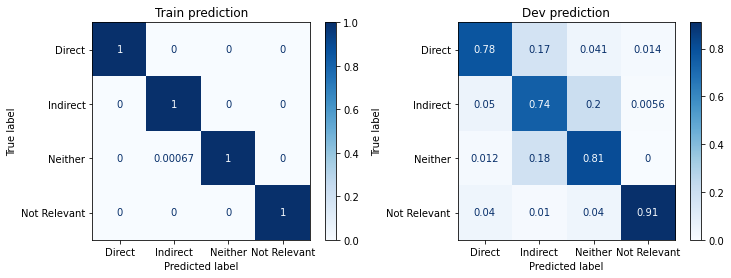

In [58]:
dir_step_list = [
    ('../results/sent_rel_BioClinicalBERT_noshuffle', 3000),
    ('../results/sent_rel_BlueBERT-Base_noshuffle', 9999),
    ('../results/sent_rel_BlueBERT-Large_noshuffle', 8000),
    ('../results/sent_rel_Clinical-Longformer2_noshuffle', 4000),
    ('../results/sent_rel_Clinical-Longformer_noshuffle', 6000),
    ('../results/sent_rel_PubMedBERT_noshuffle', 9000),
]
test_output_fname = 'test_output_dev1fit_ind.csv'

test_probs = get_ensemble(dir_step_list, split='test', ensemble='probs')
test_preds = np.argmax(test_probs, axis=1)
df_test_output = get_test_prediction_df(test_preds)
df_test_output.to_csv(os.path.join(test_output_dir, test_output_fname), index=False)
plot_results_ensemble(dir_step_list, ensemble="probs")
df_test_output

- Dev2 fit - Individual fit

Ensemble of following results
	(../results/sent_rel_PubMedBERT_noshuffle/, step 7000)
	(../results/sent_rel_BioClinicalBERT_noshuffle/, step 2000)
	(../results/sent_rel_BlueBERT-Base_noshuffle/, step 7000)
	(../results/sent_rel_BlueBERT-Large_noshuffle/, step 4000)
- Train set performance
    - Accuracy: 0.999568 (4631/4633)
    - Macro F1: 0.999631
- Dev set performance
    - Accuracy: 0.788945 (471/597)
    - Macro F1: 0.807847
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      110       28        6        1      145
Indirect        0     1248        1        0     1249 | Indirect       12      129       36        2      179
 Neither        0        1     1483        0     1484 |  Neither        2       30      141        0      173
Not Rele        0        0        0      810      810 | Not Rele        3        2        4       91      100
Pred cnt     109

,ROW ID,HADM ID,Assessment,Plan Subsection,Relation
0,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Sepsis\n likely has sepsis physiology with hyp...,Direct
1,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Anuria- Renal consulted for anuria- consideri...,Indirect
2,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,R pleural effusion: Unilateral nature in the s...,Indirect
3,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,DM/hypoglycemia: possibly from not clearing me...,Indirect
4,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,S/p recent femur fracture: held SQH overnight,Neither
...,...,...,...,...,...
662,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",5) HTN: Cont lisinopril,Neither
663,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",6) CRI: Last Cr 1.2: Hold naproxen given...,Neither
664,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","7) Nausea: likely chemo SE, cont compazi...",Neither
665,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","8) Hyperglycemia: trend, consider HISS",Neither


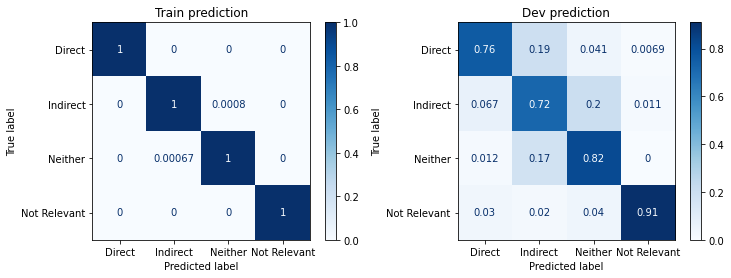

In [59]:
dir_step_list = [
    ('../results/sent_rel_PubMedBERT_noshuffle/', 7000),
    ('../results/sent_rel_BioClinicalBERT_noshuffle/', 2000),
    ('../results/sent_rel_BlueBERT-Base_noshuffle/', 7000),
    ('../results/sent_rel_BlueBERT-Large_noshuffle/', 4000),
]
test_output_fname = 'test_output_dev2fit_ind.csv'

test_probs = get_ensemble(dir_step_list, split='test', ensemble='probs')
test_preds = np.argmax(test_probs, axis=1)
df_test_output = get_test_prediction_df(test_preds)
df_test_output.to_csv(os.path.join(test_output_dir, test_output_fname), index=False)
plot_results_ensemble(dir_step_list, ensemble="probs")
df_test_output

- Dev1 fit - Joint fit

Ensemble of following results
	(../results/sent_rel_PubMedBERT_noshuffle/, step 9000)
	(../results/sent_rel_BioClinicalBERT_noshuffle/, step 9999)
	(../results/sent_rel_BlueBERT-Base_noshuffle/, step 9999)
	(../results/sent_rel_BlueBERT-Large_noshuffle/, step 9999)
- Train set performance
    - Accuracy: 0.999784 (4632/4633)
    - Macro F1: 0.999816
- Dev set performance
    - Accuracy: 0.802345 (479/597)
    - Macro F1: 0.820019
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      112       25        6        2      145
Indirect        0     1249        0        0     1249 | Indirect        8      133       36        2      179
 Neither        0        1     1483        0     1484 |  Neither        1       29      143        0      173
Not Rele        0        0        0      810      810 | Not Rele        2        3        4       91      100
Pred cnt     109

,ROW ID,HADM ID,Assessment,Plan Subsection,Relation
0,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Sepsis\n likely has sepsis physiology with hyp...,Direct
1,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Anuria- Renal consulted for anuria- consideri...,Indirect
2,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,R pleural effusion: Unilateral nature in the s...,Indirect
3,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,DM/hypoglycemia: possibly from not clearing me...,Indirect
4,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,S/p recent femur fracture: held SQH overnight,Neither
...,...,...,...,...,...
662,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",5) HTN: Cont lisinopril,Neither
663,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",6) CRI: Last Cr 1.2: Hold naproxen given...,Neither
664,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","7) Nausea: likely chemo SE, cont compazi...",Neither
665,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","8) Hyperglycemia: trend, consider HISS",Neither


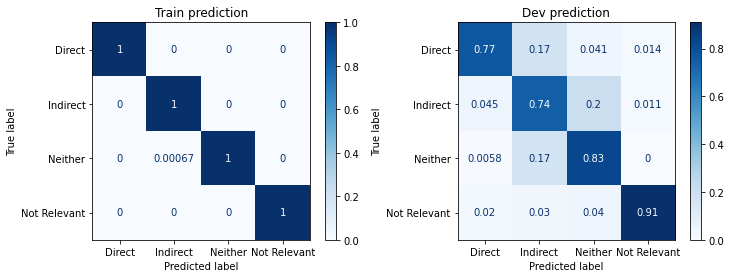

In [60]:
dir_step_list = [
    ('../results/sent_rel_PubMedBERT_noshuffle/', 9000),
    ('../results/sent_rel_BioClinicalBERT_noshuffle/', 9999),
    ('../results/sent_rel_BlueBERT-Base_noshuffle/', 9999),
    ('../results/sent_rel_BlueBERT-Large_noshuffle/', 9999),
]
test_output_fname = 'test_output_dev1fit_comb.csv'

test_probs = get_ensemble(dir_step_list, split='test', ensemble='probs')
test_preds = np.argmax(test_probs, axis=1)
df_test_output = get_test_prediction_df(test_preds)
df_test_output.to_csv(os.path.join(test_output_dir, test_output_fname), index=False)
plot_results_ensemble(dir_step_list, ensemble="probs")
df_test_output

- Dev2 fit - Joint fit

Ensemble of following results
	(../results/sent_rel_PubMedBERT_noshuffle/, step 9999)
	(../results/sent_rel_BioClinicalBERT_noshuffle/, step 7000)
	(../results/sent_rel_BlueBERT-Base_noshuffle/, step 2000)
	(../results/sent_rel_BlueBERT-Large_noshuffle/, step 9999)
- Train set performance
    - Accuracy: 0.999784 (4632/4633)
    - Macro F1: 0.999816
- Dev set performance
    - Accuracy: 0.809045 (483/597)
    - Macro F1: 0.826760
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      115       23        6        1      145
Indirect        0     1249        0        0     1249 | Indirect       12      130       36        1      179
 Neither        0        1     1483        0     1484 |  Neither        1       26      146        0      173
Not Rele        0        0        0      810      810 | Not Rele        2        2        4       92      100
Pred cnt     109

,ROW ID,HADM ID,Assessment,Plan Subsection,Relation
0,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Sepsis\n likely has sepsis physiology with hyp...,Direct
1,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Anuria- Renal consulted for anuria- consideri...,Indirect
2,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,R pleural effusion: Unilateral nature in the s...,Indirect
3,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,DM/hypoglycemia: possibly from not clearing me...,Indirect
4,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,S/p recent femur fracture: held SQH overnight,Neither
...,...,...,...,...,...
662,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",5) HTN: Cont lisinopril,Neither
663,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",6) CRI: Last Cr 1.2: Hold naproxen given...,Neither
664,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","7) Nausea: likely chemo SE, cont compazi...",Neither
665,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","8) Hyperglycemia: trend, consider HISS",Neither


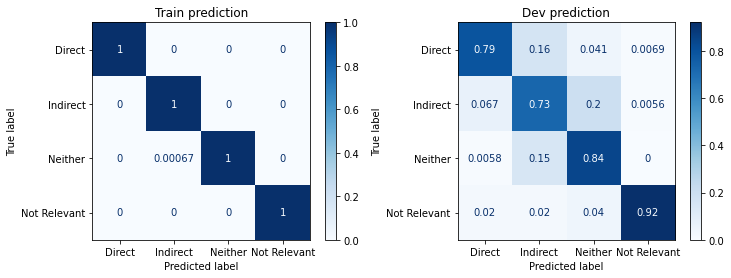

In [61]:
dir_step_list = [
    ('../results/sent_rel_PubMedBERT_noshuffle/', 9999),
    ('../results/sent_rel_BioClinicalBERT_noshuffle/', 7000),
    ('../results/sent_rel_BlueBERT-Base_noshuffle/', 2000),
    ('../results/sent_rel_BlueBERT-Large_noshuffle/', 9999),
]
test_output_fname = 'test_output_dev2fit_comb.csv'

test_probs = get_ensemble(dir_step_list, split='test', ensemble='probs')
test_preds = np.argmax(test_probs, axis=1)
df_test_output = get_test_prediction_df(test_preds)
df_test_output.to_csv(os.path.join(test_output_dir, test_output_fname), index=False)
plot_results_ensemble(dir_step_list, ensemble="probs")
df_test_output

- Dev fit - Joint fit

Ensemble of following results
	(../results/sent_rel_BioClinicalBERT/, step 9000)
	(../results/sent_rel_BlueBERT-Base_noshuffle/, step 9999)
	(../results/sent_rel_BlueBERT-Base/, step 9999)
	(../results/sent_rel_BlueBERT-Large_noshuffle/, step 7000)
	(../results/sent_rel_BlueBERT-Large/, step 7000)
	(../results/sent_rel_Clinical-Longformer_noshuffle/, step 9999)
	(../results/sent_rel_Clinical-Longformer2_noshuffle/, step 9000)
- Train set performance
    - Accuracy: 1.000000 (4633/4633)
    - Macro F1: 1.000000
- Dev set performance
    - Accuracy: 0.815745 (487/597)
    - Macro F1: 0.831736
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      113       23        7        2      145
Indirect        0     1249        0        0     1249 | Indirect        9      139       30        1      179
 Neither        0        0     1484        0     1484 |  Neither        

,ROW ID,HADM ID,Assessment,Plan Subsection,Relation
0,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Sepsis\n likely has sepsis physiology with hyp...,Direct
1,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Anuria- Renal consulted for anuria- consideri...,Indirect
2,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,R pleural effusion: Unilateral nature in the s...,Indirect
3,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,DM/hypoglycemia: possibly from not clearing me...,Indirect
4,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,S/p recent femur fracture: held SQH overnight,Neither
...,...,...,...,...,...
662,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",5) HTN: Cont lisinopril,Neither
663,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",6) CRI: Last Cr 1.2: Hold naproxen given...,Neither
664,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","7) Nausea: likely chemo SE, cont compazi...",Neither
665,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","8) Hyperglycemia: trend, consider HISS",Neither


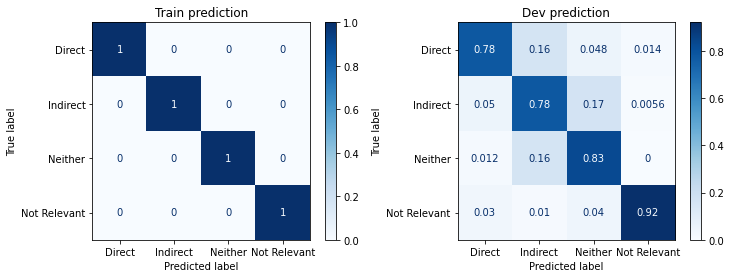

In [62]:
dir_step_list = [
#     ('../results/sent_rel_PubMedBERT_noshuffle/'          , 0),
#     ('../results/sent_rel_PubMedBERT/'                    , 0),
#     ('../results/sent_rel_BioClinicalBERT_noshuffle/'     , 0),
    ('../results/sent_rel_BioClinicalBERT/'               , 9000),
    ('../results/sent_rel_BlueBERT-Base_noshuffle/'       , 9999),
    ('../results/sent_rel_BlueBERT-Base/'                 , 9999),
    ('../results/sent_rel_BlueBERT-Large_noshuffle/'      , 7000),
    ('../results/sent_rel_BlueBERT-Large/'                , 7000),
    ('../results/sent_rel_Clinical-Longformer_noshuffle/' , 9999),
#     ('../results/sent_rel_Clinical-Longformer/'           , 0),
    ('../results/sent_rel_Clinical-Longformer2_noshuffle/', 9000),
#     ('../results/sent_rel_Clinical-Longformer2/'          , 0),
]
test_output_fname = 'test_output_devfit_comb.csv'

test_probs = get_ensemble(dir_step_list, split='test', ensemble='probs')
test_preds = np.argmax(test_probs, axis=1)
df_test_output = get_test_prediction_df(test_preds)
df_test_output.to_csv(os.path.join(test_output_dir, test_output_fname), index=False)
plot_results_ensemble(dir_step_list, ensemble="probs")
df_test_output

## Ensemble 2. Use the last checkpoints of the train+dev models

- Last - CBERT (Shuffle X) / train + dev

In [63]:
dir_step_list = [
    ('../results/sent_rel_PubMedBERT_noshuffle_traindev/', 9999),
    ('../results/sent_rel_BioClinicalBERT_noshuffle_traindev/', 9999),
    ('../results/sent_rel_BlueBERT-Base_noshuffle_traindev/', 9999),
    ('../results/sent_rel_BlueBERT-Large_noshuffle_traindev/', 9999),
]
test_output_fname = 'test_output_CBERT_noshuffle_traindev_last.csv'

test_probs = get_ensemble(dir_step_list, split='test', ensemble='probs')
test_preds = np.argmax(test_probs, axis=1)
df_test_output = get_test_prediction_df(test_preds)
df_test_output.to_csv(os.path.join(test_output_dir, test_output_fname), index=False)
df_test_output

,ROW ID,HADM ID,Assessment,Plan Subsection,Relation
0,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Sepsis\n likely has sepsis physiology with hyp...,Direct
1,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Anuria- Renal consulted for anuria- consideri...,Indirect
2,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,R pleural effusion: Unilateral nature in the s...,Indirect
3,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,DM/hypoglycemia: possibly from not clearing me...,Indirect
4,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,S/p recent femur fracture: held SQH overnight,Neither
...,...,...,...,...,...
662,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",5) HTN: Cont lisinopril,Neither
663,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",6) CRI: Last Cr 1.2: Hold naproxen given...,Neither
664,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","7) Nausea: likely chemo SE, cont compazi...",Neither
665,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","8) Hyperglycemia: trend, consider HISS",Neither


- Last - All models (Shuffle X) / train + dev

In [64]:
dir_step_list = [
    ('../results/sent_rel_bert-base-uncased_noshuffle_traindev/', 9999),
    ('../results/sent_rel_PubMedBERT_noshuffle_traindev/', 9999),
    ('../results/sent_rel_BioClinicalBERT_noshuffle_traindev/', 9999),
    ('../results/sent_rel_BlueBERT-Base_noshuffle_traindev/', 9999),
    ('../results/sent_rel_BlueBERT-Large_noshuffle_traindev/', 9999),
    ('../results/sent_rel_Clinical-Longformer_noshuffle_traindev/', 9999),
    ('../results/sent_rel_Clinical-Longformer2_noshuffle_traindev/', 9999),
]
test_output_fname = 'test_output_all_noshuffle_traindev_last.csv'

test_probs = get_ensemble(dir_step_list, split='test', ensemble='probs')
test_preds = np.argmax(test_probs, axis=1)
df_test_output = get_test_prediction_df(test_preds)
df_test_output.to_csv(os.path.join(test_output_dir, test_output_fname), index=False)
df_test_output

,ROW ID,HADM ID,Assessment,Plan Subsection,Relation
0,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Sepsis\n likely has sepsis physiology with hyp...,Direct
1,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Anuria- Renal consulted for anuria- consideri...,Indirect
2,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,R pleural effusion: Unilateral nature in the s...,Neither
3,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,DM/hypoglycemia: possibly from not clearing me...,Indirect
4,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,S/p recent femur fracture: held SQH overnight,Neither
...,...,...,...,...,...
662,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",5) HTN: Cont lisinopril,Neither
663,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",6) CRI: Last Cr 1.2: Hold naproxen given...,Neither
664,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","7) Nausea: likely chemo SE, cont compazi...",Neither
665,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","8) Hyperglycemia: trend, consider HISS",Neither


- Last - CBERT (Shuffle OX) / train + dev

In [65]:
dir_step_list = [
    ('../results/sent_rel_PubMedBERT_noshuffle_traindev/', 9999),
    ('../results/sent_rel_PubMedBERT_traindev/', 9999),
    ('../results/sent_rel_BioClinicalBERT_noshuffle_traindev/', 9999),
    ('../results/sent_rel_BioClinicalBERT_traindev/', 9999),
    ('../results/sent_rel_BlueBERT-Base_noshuffle_traindev/', 9999),
    ('../results/sent_rel_BlueBERT-Base_traindev/', 9999),
    ('../results/sent_rel_BlueBERT-Large_noshuffle_traindev/', 9999),
    ('../results/sent_rel_BlueBERT-Large_traindev/', 9999),
]
test_output_fname = 'test_output_CBERT_allshuffle_traindev_last.csv'

test_probs = get_ensemble(dir_step_list, split='test', ensemble='probs')
test_preds = np.argmax(test_probs, axis=1)
df_test_output = get_test_prediction_df(test_preds)
df_test_output.to_csv(os.path.join(test_output_dir, test_output_fname), index=False)
df_test_output

,ROW ID,HADM ID,Assessment,Plan Subsection,Relation
0,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Sepsis\n likely has sepsis physiology with hyp...,Direct
1,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Anuria- Renal consulted for anuria- consideri...,Indirect
2,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,R pleural effusion: Unilateral nature in the s...,Indirect
3,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,DM/hypoglycemia: possibly from not clearing me...,Indirect
4,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,S/p recent femur fracture: held SQH overnight,Neither
...,...,...,...,...,...
662,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",5) HTN: Cont lisinopril,Neither
663,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",6) CRI: Last Cr 1.2: Hold naproxen given...,Neither
664,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","7) Nausea: likely chemo SE, cont compazi...",Neither
665,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","8) Hyperglycemia: trend, consider HISS",Neither


- Last - All models (Shuffle OX) / train + dev

In [66]:
dir_step_list = [
    ('../results/sent_rel_bert-base-uncased_noshuffle_traindev/', 9999),
    ('../results/sent_rel_bert-base-uncased_traindev/', 9999),
    ('../results/sent_rel_PubMedBERT_noshuffle_traindev/', 9999),
    ('../results/sent_rel_PubMedBERT_traindev/', 9999),
    ('../results/sent_rel_BioClinicalBERT_noshuffle_traindev/', 9999),
    ('../results/sent_rel_BioClinicalBERT_traindev/', 9999),
    ('../results/sent_rel_BlueBERT-Base_noshuffle_traindev/', 9999),
    ('../results/sent_rel_BlueBERT-Base_traindev/', 9999),
    ('../results/sent_rel_BlueBERT-Large_noshuffle_traindev/', 9999),
    ('../results/sent_rel_BlueBERT-Large_traindev/', 9999),
    ('../results/sent_rel_Clinical-Longformer_noshuffle_traindev/', 9999),
    ('../results/sent_rel_Clinical-Longformer_traindev/', 9999),
    ('../results/sent_rel_Clinical-Longformer2_noshuffle_traindev/', 9999),
    ('../results/sent_rel_Clinical-Longformer2_traindev/', 9999),
]
test_output_fname = 'test_output_all_allshuffle_traindev_last.csv'

test_probs = get_ensemble(dir_step_list, split='test', ensemble='probs')
test_preds = np.argmax(test_probs, axis=1)
df_test_output = get_test_prediction_df(test_preds)
df_test_output.to_csv(os.path.join(test_output_dir, test_output_fname), index=False)
df_test_output

,ROW ID,HADM ID,Assessment,Plan Subsection,Relation
0,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Sepsis\n likely has sepsis physiology with hyp...,Direct
1,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Anuria- Renal consulted for anuria- consideri...,Indirect
2,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,R pleural effusion: Unilateral nature in the s...,Indirect
3,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,DM/hypoglycemia: possibly from not clearing me...,Indirect
4,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,S/p recent femur fracture: held SQH overnight,Neither
...,...,...,...,...,...
662,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",5) HTN: Cont lisinopril,Neither
663,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",6) CRI: Last Cr 1.2: Hold naproxen given...,Neither
664,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","7) Nausea: likely chemo SE, cont compazi...",Neither
665,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","8) Hyperglycemia: trend, consider HISS",Neither
